This notebook requires `fairlearn`, run the below command in a Jupyter Notebook cell if `fairlearn` is not yet in your environment:
```
!pip install fairlearn
```

In [1]:
import ehrapy as ep
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tableone import TableOne

import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.metrics import MetricFrame, false_negative_rate, selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

In [2]:
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

In [3]:
# cohorttracker "colorblind" color palette
colors = sns.color_palette("colorblind", n_colors=14)

In [4]:
adata_algo = ep.dt.diabetes_130_fairlearn(
    columns_obs_only=[
        "race",
        "gender",
        "age",
        "readmitted",
        "readmit_binary",
        "discharge_disposition_id",
    ]
)
adata_algo.obs["readmit_30_days"] = adata_algo.obs["readmitted"] == "<30"

In [5]:
TableOne(adata_algo.obs, columns=["race", "gender", "age"])

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

In [6]:
# aggregate small groups
adata_algo.obs["race_all"] = adata_algo.obs["race"]
adata_algo.obs["race"] = adata_algo.obs["race"].replace(
    {"Asian": "Other", "Hispanic": "Other"}
)

# drop gender group Unknown/Invalid
adata_algo = adata_algo[adata_algo.obs["gender"] != "Unknown/Invalid", :].copy()
ep.ad.move_to_x(adata_algo, "gender")

AnnData object with n_obs × n_vars = 101763 × 19
    obs: 'race', 'age', 'readmitted', 'readmit_binary', 'discharge_disposition_id', 'readmit_30_days', 'race_all'

In [7]:
# encode categorical data to one-hot
adata_algo = ep.pp.encode(
    adata_algo,
    autodetect=True,
)

❗ Features 'time_in_hospital', 'num_procedures', 'number_diagnoses' were detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
❗ Feature types were inferred and stored in adata.var[feature_type]. Please verify using `ep.ad.feature_type_overview` and adjust if necessary using `ep.ad.replace_feature_types`.


Output()

In [8]:
# train-test 50-50 split
train_idxs, test_idxs = train_test_split(
    np.arange(adata_algo.n_obs),
    stratify=adata_algo.obs["race"],
    test_size=0.5,
    random_state=0,
)
adata_algo_train = adata_algo[train_idxs, :]
adata_algo_test = adata_algo[test_idxs, :]

In [9]:
adata_algo_train

View of AnnData object with n_obs × n_vars = 50881 × 45
    obs: 'race', 'gender', 'age', 'readmitted', 'readmit_binary', 'discharge_disposition_id', 'readmit_30_days', 'race_all', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days'
    var: 'feature_type', 'unencoded_var_names', 'encoding_mode'
    layers: 'original'

In [10]:
adata_algo_test

View of AnnData object with n_obs × n_vars = 50882 × 45
    obs: 'race', 'gender', 'age', 'readmitted', 'readmit_binary', 'discharge_disposition_id', 'readmit_30_days', 'race_all', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days'
    var: 'feature_type', 'unencoded_var_names', 'encoding_mode'
    layers: 'original'

In [11]:
# train set balanced for readmit_30_days label
adata_algo_train_balanced = ep.pp.balanced_sample(
    adata_algo_train,
    key="readmit_30_days",
    method="RandomUnderSampler",
    random_state=0,
    copy=True,
)
adata_algo_train_balanced.obs["readmit_30_days"].value_counts()

readmit_30_days
False    5667
True     5667
Name: count, dtype: int64

In [12]:
unmitigated_pipeline = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("logistic_regression", LogisticRegression(max_iter=1000)),
    ]
)

In [13]:
unmitigated_pipeline.fit(
    adata_algo_train_balanced.X,
    adata_algo_train_balanced.obs["readmit_30_days"].astype(bool),
)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

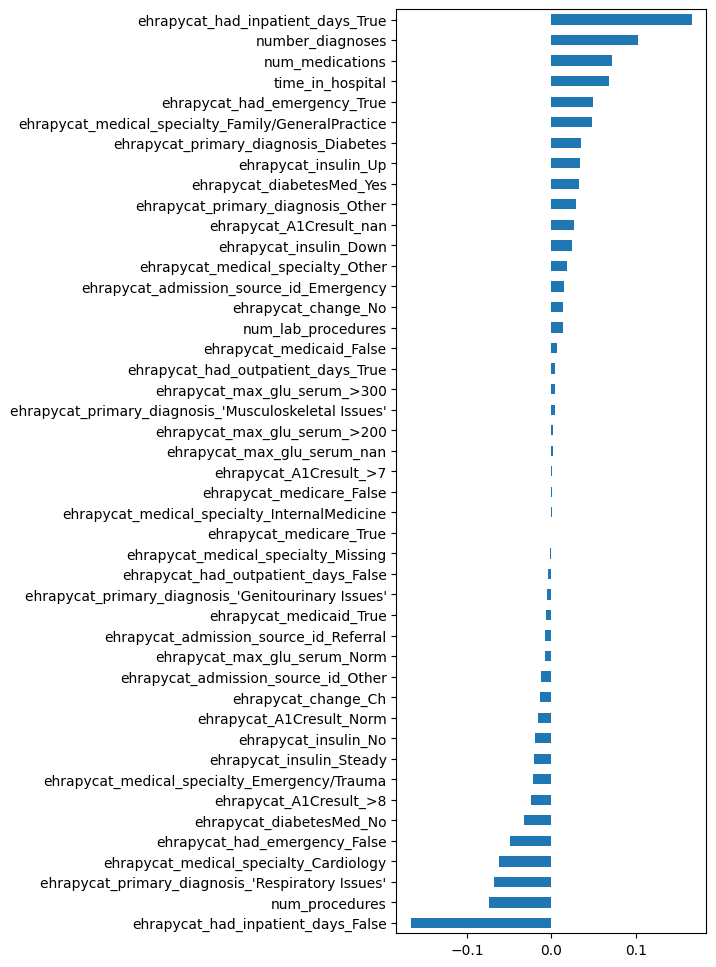

In [14]:
coef_series = pd.Series(
    data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0],
    index=adata_algo_train_balanced.var_names,
)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

In [15]:
Y_pred_proba = unmitigated_pipeline.predict_proba(adata_algo_test.X)[:, 1]
Y_pred = unmitigated_pipeline.predict(adata_algo_test.X)

In [16]:
balanced_accuracy_score(
    adata_algo_test.obs["readmit_30_days"].astype(bool), Y_pred.astype(bool)
)

In [17]:
metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

mf1 = MetricFrame(
    metrics=metrics_dict,
    y_true=adata_algo_test.obs["readmit_30_days"],
    y_pred=Y_pred,
    sensitive_features=adata_algo_test.obs["race"],
)

mf1.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.400833,0.419385,0.601196
Caucasian,0.382129,0.461288,0.588269
Other,0.321224,0.483568,0.608668
Unknown,0.231718,0.611650,0.586132


In [18]:
df_long = pd.melt(
    mf1.by_group.reset_index(), id_vars=["race"], var_name="metric", value_name="value"
)

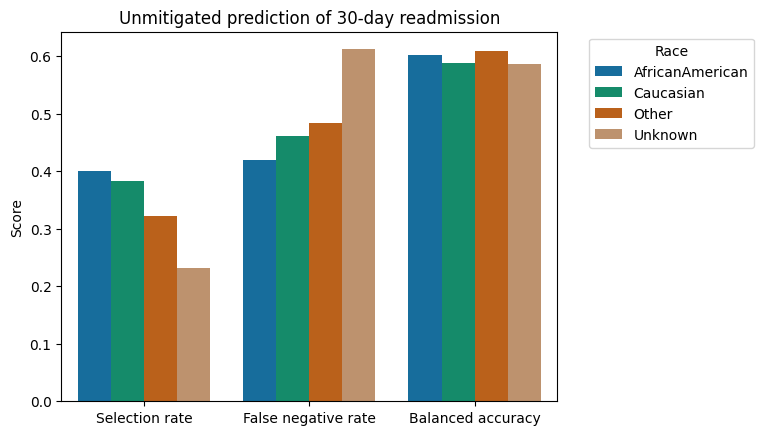

In [19]:
# colors from cohorttracker where groups are available
palette = [colors[0], colors[2], colors[3], colors[5]]

fig, ax = plt.subplots()
bar = sns.barplot(data=df_long, x="metric", y="value", hue="race", palette=palette)
ax.legend(title="Race", bbox_to_anchor=(1.05, 1))
ax.set_ylabel("Score")
ax.set_xlabel(None)
ax.set_title("Unmitigated prediction of 30-day readmission")
ax.set_xticklabels(
    labels=["Selection rate", "False negative rate", "Balanced accuracy"]
)

plt.savefig("algorithmic_bias_1.pdf", dpi=300, bbox_inches="tight")

In [21]:
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)
postprocess_est.fit(
    adata_algo_train_balanced.X,
    adata_algo_train_balanced.obs["readmit_30_days"],
    sensitive_features=adata_algo_train_balanced.obs["race"],
)
Y_pred_postprocess = postprocess_est.predict(
    adata_algo_test.X, sensitive_features=adata_algo_test.obs["race"]
)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=adata_algo_test.obs["readmit_30_days"],
    y_pred=Y_pred_postprocess,
    sensitive_features=adata_algo_test.obs["race"],
)
pd.concat(
    [mf1.by_group, metricframe_postprocess.by_group],
    keys=["Unmitigated", "ThresholdOptimizer"],
    axis=1,
)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican       0.400833            0.419385          0.601196   
Caucasian             0.382129            0.461288          0.588269   
Other                 0.321224            0.483568          0.608668   
Unknown               0.231718            0.611650          0.586132   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican           0.374492            0.448276          0.599760  
Caucasian                 0.399133            0.444315          0.588252  
Other                     0.382887            0.417840          0.610931  
Unknown                   0.429956            0.446602          0.567881

In [22]:
Y_pred_mitig = postprocess_est.predict(
    adata_algo_test.X, sensitive_features=adata_algo_test.obs["race"]
)
balanced_accuracy_score(
    adata_algo_test.obs["readmit_30_days"].astype(bool), Y_pred_mitig.astype(bool)
)

In [23]:
df_long_postprocess = pd.melt(
    metricframe_postprocess.by_group.reset_index(),
    id_vars=["race"],
    var_name="metric",
    value_name="value",
)

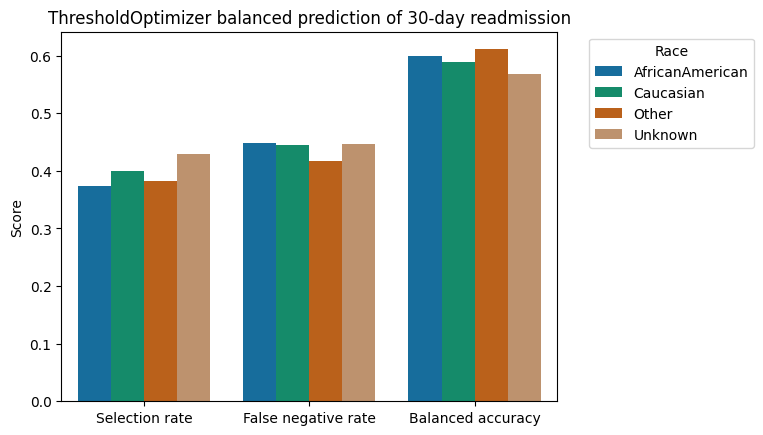

In [25]:
palette = [colors[0], colors[2], colors[3], colors[5]]

fig, ax = plt.subplots()
bar = sns.barplot(
    data=df_long_postprocess, x="metric", y="value", hue="race", palette=palette
)

ax.legend(title="Race", bbox_to_anchor=(1.05, 1))
ax.set_ylabel("Score")
ax.set_xlabel(None)
ax.set_xticklabels(
    labels=["Selection rate", "False negative rate", "Balanced accuracy"]
)
ax.set_title("ThresholdOptimizer balanced prediction of 30-day readmission")

max_heights = df_long_postprocess.groupby("metric")["value"].max()

plt.savefig("algorithmic_bias_2.pdf", dpi=300, bbox_inches="tight")